# ECG Classification (PhysioNet/CinC Challenge 2017)

0. Download data
1. Data augmentation: WaveNet
2. Model: Attention-based CRNN (attention in last layer)
3. **Explain (important)**: Explainable predictions with the classifier

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from google.colab import output
from collections import Counter
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

print("PyTorch version:", torch.__version__)
print("GPU is", "available" if torch.cuda.is_available() else "NOT available" + 
      "!!!\n Change Runtime > runtime type and set Hardware accelerator to GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 1.5.1
GPU is NOT available!!!
 Change Runtime > runtime type and set Hardware accelerator to GPU


In [2]:
try:
  from tensorboardX import SummaryWriter
except:
  %pip install tensorboardX
  from tensorboardX import SummaryWriter
try:
  from torchsummaryX import summary
except:
  %pip install torchsummaryX
  from torchsummaryX import summary
try:
  import visdom
except:
  %pip install visdom
  import visdom
from audiodata import AudioData, AudioLoader
from models import Model, Generator
output.clear()

In [3]:
# Download preprocessed data from <https://drive.google.com/drive/folders/1AuPxvGoyUbKcVaFmeyt3xsqj6ucWZezf>
DATA_PATH="challenge2017.pkl"
if not os.path.exists(DATA_PATH):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1j7Yk0-W9uonQiyyG2B9ZAw5jjZA-UeMS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1j7Yk0-W9uonQiyyG2B9ZAw5jjZA-UeMS" -O challenge2017.pkl && rm -rf /tmp/cookies.txt
  output.clear()
  print("Data challenge2017.pkl downloaded!")
# !ls
# challenge2017.pkl should be 160M
!du -h challenge2017.pkl

160M	challenge2017.pkl


## 0. Preprocess Data

In [4]:
def slide_and_cut(X, Y, window_size, stride, output_pid=False, datatype=4):
  out_X = []
  out_Y = []
  out_pid = []
  n_sample = X.shape[0]
  mode = 0
  for i in range(n_sample):
    tmp_ts = X[i]
    tmp_Y = Y[i]
    if tmp_Y == 0:
      i_stride = stride
    elif tmp_Y == 1:
      if datatype == 4:
        i_stride = stride//6
      elif datatype == 2:
        i_stride = stride//10
      elif datatype == 2.1:
        i_stride = stride//7
    elif tmp_Y == 2:
      i_stride = stride//2
    elif tmp_Y == 3:
      i_stride = stride//20
    for j in range(0, len(tmp_ts)-window_size, i_stride):
      out_X.append(tmp_ts[j:j+window_size])
      out_Y.append(tmp_Y)
      out_pid.append(i)
  if output_pid:
    return np.array(out_X), np.array(out_Y), np.array(out_pid)
  else:
    return np.array(out_X), np.array(out_Y)


def read_data(DATA_PATH, window_size=2048, stride=512, cut=False, bit=True):
  """
  only N A, no O P
  """
  # Read data
  with open(DATA_PATH, 'rb') as fin:
    res = pickle.load(fin)
  ## only N A, no O P
  all_data = []
  all_label = []
  all_max = 0
  for i in range(len(res['label'])):
    if np.abs(res['data'][i]).max() > all_max:
      all_max = np.abs(res['data'][i]).max()
    if res['label'][i] == 'A':
      all_label.append(1)
      all_data.append(res['data'][i])
    elif res['label'][i] == 'N':
      all_label.append(0)
      all_data.append(res['data'][i])
  ## scale data
  for i in range(len(all_data)):
    tmp_data = all_data[i]
    tmp_std = np.std(tmp_data)
    tmp_mean = np.mean(tmp_data)
    all_data[i] = (tmp_data - tmp_mean) / tmp_std
    if bit:
      # note: devide first, in case of overflow
      all_data[i] = np.asarray(all_data[i] / all_max * np.iinfo(np.int16).max, dtype=np.int16)
  
  all_data = np.array(all_data)
  all_label = np.array(all_label)
  if not cut:
    return all_data, all_label
  else:
    # split train test
    X_train, X_test, Y_train, Y_test = train_test_split(
        all_data, all_label, test_size=0.1, random_state=0)
    
    # slide and cut
    print('before: ')
    print(Counter(Y_train), Counter(Y_test))
  
    X_train, Y_train = slide_and_cut(
        X_train, Y_train, window_size=window_size, stride=stride, datatype=2.1)
    X_test, Y_test, pid_test = slide_and_cut(
        X_test, Y_test, window_size=window_size, stride=stride, datatype=2.1, output_pid=True)
    print('after: ')
    print(Counter(Y_train), Counter(Y_test))
  
    # shuffle train
    shuffle_pid = np.random.permutation(Y_train.shape[0])
    X_train = X_train[shuffle_pid]
    Y_train = Y_train[shuffle_pid]

    X_train = np.expand_dims(X_train, 1)
    X_test = np.expand_dims(X_test, 1)
    return X_train, X_test, Y_train, Y_test, pid_test
    

class MyDataset(Dataset):
  def __init__(self, data, label):
    self.data = data
    self.label = label

  def __getitem__(self, index):
    return (torch.tensor(self.data[index], dtype=torch.float), 
            torch.tensor(self.label[index], dtype=torch.long))

  def __len__(self):
    return len(self.data)


In [5]:
batch_size = 128
n_epoch = 200
win_size = 2048
stride = 512
""" Get original data, in np.int16 dtype """
all_data, all_label = read_data(
    DATA_PATH, window_size=win_size, stride=stride, cut=False, bit=True)

In [6]:
'''
# DEMO (note: data is preprocessed.)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
# plot 'A' and 'N' sample
for i in range(2):
  axs[i].plot(all_data[np.where(all_label==i)[0][0]][:2048])
  axs[i].set_title('A' if i else 'N')

plt.show()
'''
pass

## 1. Data Augmentation

Implemente WaveNet to augment data. Reference: [Wavenet-PyTorch](https://github.com/Dankrushen/Wavenet-PyTorch).


In [7]:
'''
A_data = all_data[np.where(all_label==1)]
N_data = all_data[np.where(all_label==0)]
print(A_data.shape, N_data.shape)
# The data is unbalanced: A << N (758 v.s. 5076)
'''
pass

In [8]:
x_len = 2**11
num_channels=1
num_classes = 256 # digitize parameter
num_layers = 9
num_blocks = 2
num_hidden = 32 # larger: trained slower and precision decreased; smaller: trn_loss decrease very slow
kernel_size = 2
learn_rate = 0.001
step_size = 100
gamma = 0.9
batch_size = 16
num_workers = 1
num_epochs = 1000
A_model_file = 'A_Wavenet_990_0.2105.pt'
N_model_file = 'N_Wavenet_1000_0.1569'
use_visdom = False
n_new_samples = win_size
disp_interval = 10
n_predictions = 1024
n_total_samples = n_predictions + x_len

In [9]:
def get_ylen(x_len, num_layers, num_blocks, kernel_size):
    rec_field = 1 + (kernel_size - 1) * \
                num_blocks * sum([2**k for k in range(num_layers)])
    return x_len - rec_field

y_len = get_ylen(x_len, num_layers, num_blocks, kernel_size)
print('x_len: {}, y_len: {}, rec_field: {}'.format(x_len, y_len, x_len-y_len))

x_len: 2048, y_len: 1025, rec_field: 1023


In [10]:
'''
A_wave_model = Model(x_len, 
                   num_channels=num_channels, 
                   num_classes=num_classes, 
                   num_blocks=num_blocks, 
                   num_layers=num_layers,
                   num_hidden=num_hidden,
                   kernel_size=kernel_size)
# load the trained wave_model
if os.path.isfile(A_model_file):
    print('Loading model data from file: {}'.format(A_model_file))
    A_wave_model.load_state_dict(torch.load(A_model_file, map_location=device))
A_wave_model.set_device(device)
'''
pass

In [11]:
'''
N_wave_model = Model(x_len, 
                   num_channels=num_channels, 
                   num_classes=num_classes, 
                   num_blocks=num_blocks, 
                   num_layers=num_layers,
                   num_hidden=num_hidden,
                   kernel_size=kernel_size)
# load the trained wave_model
if os.path.isfile(N_model_file):
    print('Loading model data from file: {}'.format(N_model_file))
    N_wave_model.load_state_dict(torch.load(N_model_file, map_location=device))
N_wave_model.set_device(device)
'''
pass

In [12]:
# ## Training / Finetune
# A_dataset = AudioData(A_data, x_len, y_len=y_len, num_classes=num_classes)
# dataloader = AudioLoader(A_dataset, batch_size=batch_size)
# finetune = False
# if finetune:
#   num_epochs = 100
#   learn_rate = learn_rate
#   wave_model.criterion = nn.CrossEntropyLoss()
#   wave_model.optimizer = optim.Adam(wave_model.parameters(), lr=learn_rate)
#   wave_model.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#       wave_model.optimizer, mode='min', factor=gamma, min_lr=1e-5, patience=100)
#   wave_model.train(dataloader, num_epochs=num_epochs, 
#                   disp_interval=disp_interval,
#                   use_visdom=False)
#   # torch.save(wave_model.state_dict(), model_file)

In [13]:
'''
A_dataset = AudioData(A_data, x_len, y_len=y_len, num_classes=num_classes)
A_wave_generator = Generator(A_wave_model, A_dataset)
N_dataset = AudioData(N_data, x_len, y_len=y_len, num_classes=num_classes)
N_wave_generator = Generator(N_wave_model, N_dataset)
'''
pass

In [14]:
'''
audio = A_data[0][:n_total_samples]
x1 = audio[:x_len]
y1 = A_wave_generator.run(x1, n_predictions)
y1 = (y1 - y1.mean()) / y1.std()
y1 = y1 / np.abs(y1).max() * np.abs(x1).max()
tmp = np.where(np.abs(y1)<=1)[0]
# y1[tmp] = x1[tmp + np.random.randint(1024)]
b, a = butter(2, 0.3) # order 3 lowpass butterworth filter, 0 < Wn < 1
y1_lf = filtfilt(b, a, y1)
y1_digit = np.asarray(y1_lf / np.abs(y1_lf).max() * np.abs(x1).max(), dtype=np.int16)

audio = N_data[1][:n_total_samples]
x2 = audio[:x_len]
y2 = N_wave_generator.run(x2, n_predictions//2)
y2 = (y2 - y2.mean()) / y2.std()
y2 = y2 / np.abs(y2).max() * np.abs(x2).max()
tmp = np.where(np.abs(y2)<=1)[0]
# y2[tmp] = x2[tmp + np.random.randint(1024)]
b, a = butter(2, 0.3) # order 3 lowpass butterworth filter, 0 < Wn < 1
y2_lf = filtfilt(b, a, y2)
y2_digit = np.asarray(y2_lf / np.abs(y2_lf).max() * np.abs(x2).max(), dtype=np.int16)

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 12))
axs[0].plot(x1[:1024])
axs[0].set_title('A')
axs[1].plot(y1_digit)
axs[1].set_title('A generated')
axs[-2].plot(x2[:1024])
axs[-2].set_title('N')
axs[-1].plot(y2_digit)
axs[-1].set_title('N generated')

plt.show()
'''
pass

In [15]:
# Data augmentation
def slice_data(dataset, x_len=x_len, hop=x_len//2):
  """ Method
  1. Input: (N, variable_length) for each in N:
  2. cut(ij, x_len) and slide hop
  |-------data_len-------|
  |---x_len---|
  hop|---x_len---|
  hop|hop|---x_len---|
  hop|hop|hop|---x_len---|
  """
  out_X = []
  if dataset[0].shape:
    for i in range(len(dataset)):
      audio = dataset[i]
      n_slices = (len(audio) - x_len) // hop + 1
      audio_slices = []
      for j in range(n_slices):
        audio_slices.append(audio[j*hop:j*hop+x_len])

      out_X.extend(audio_slices)
  else:
    audio = dataset
    n_slices = (len(audio) - x_len) // hop + 1
    audio_slices = []
    for j in range(n_slices):
      audio_slices.append(audio[j*hop:j*hop+x_len])

    out_X.extend(audio_slices)
  return np.asarray(out_X)

def generate_data(dataset, wave_generator,  n_pred=n_predictions, x_len=x_len, hop=x_len//4, lf=False):
  """ Method
  |--------------data_len-------------|
  |---x_len---|---x_len---|---x_len---|
  |---x_len---|n_pred|---x_len---|n_pred|---x_len---|
  Then slide and cut
  """
  out_X = []
  for i in range(len(dataset)):
    audio = dataset[i]
    n_inserts = len(audio) // x_len - 1
    audio_slices = []
    for j in range(n_inserts):
      x = audio[j*(x_len+n_pred) : j*(x_len+n_pred)+x_len]
      y = wave_generator.run(x, n_pred)
      # if y.max() + y.min() < 0:
      #   y = -y
      y = (y - y.mean()) / (y.std() + 1e-8)
      # tmp = np.where(np.abs(y)<=1)[0]
      # y[tmp] = x[tmp + np.random.randint(n_pred)]
      if lf:
        y_lf = filtfilt(b, a, y)
        y_digit = np.asarray(y_lf / (np.abs(y_lf).max() + 1e-8) * np.abs(x).max(), dtype=np.int16)
        audio = np.concatenate([x, y_digit, audio[x_len:]])
      else:
        audio = np.concatenate([x, y / (np.abs(y).max() + 1e-8) * np.abs(x).max(), audio[x_len:]])

    audio_slices = slice_data(audio, x_len=x_len, hop=hop)
    out_X.extend(audio_slices)
  
  return np.asarray(out_X)


In [16]:
'''
print('before: ', A_data.shape)
A_data_new = generate_data(A_data, A_wave_generator, n_pred=n_predictions, x_len=x_len, hop=x_len//8, lf=False)
print('after: ', A_data_new.shape)
'''
pass

In [17]:
'''
print('before: ', N_data.shape)
# N_data_new = slice_data(N_data, x_len=x_len, hop=x_len//2)
N_data_new = generate_data(N_data, N_wave_generator, n_pred=n_predictions//2, x_len=x_len, hop=x_len*3//4, lf=False)
print('after: ', N_data_new.shape)
'''
pass

In [18]:
# with open('A_data_new.pkl', 'wb') as f:
#   pickle.dump(A_data_new.reshape(-1, 1, 2048), f)
# with open('N_data_new.pkl', 'wb') as f:
#   pickle.dump(N_data_new.reshape(-1, 1, 2048), f)
with open('A_data_new.pkl', 'rb') as f:
  A_data_new = pickle.load(f)
with open('N_data_new.pkl', 'rb') as f:
  N_data_new = pickle.load(f)

In [19]:
# # A:1, N:0
all_data_new = np.concatenate([A_data_new, N_data_new])
all_label_new = np.concatenate([np.ones(A_data_new.shape[0], dtype=int), np.zeros(N_data_new.shape[0], dtype=int)])
X_train, X_test, Y_train, Y_test = train_test_split(
    all_data_new.reshape(-1, 1, x_len), all_label_new, test_size=0.1, random_state=0)
print(Counter(Y_train), Counter(Y_test))
print('train test shape: ', X_train.shape, X_test.shape)

Counter({1: 29864, 0: 29558}) Counter({0: 3348, 1: 3255})
train test shape:  (59422, 1, 2048) (6603, 1, 2048)


In [20]:
dataset = MyDataset(X_train, Y_train)
dataset_test = MyDataset(X_test, Y_test)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, drop_last=False)

## 2. Model
>CNN (-> mean) -> RNN (-> squeeze) -> Attention

The attention model is illustrated in [Multi-class Arrhythmia detection](https://www.sciencedirect.com/science/article/pii/S1566253518307632). 

In [21]:
# """ Get Slid and cut augmented data """
# # before: Counter({0: 4580, 1: 670}) Counter({0: 496, 1: 88})
# X_train, X_test, Y_train, Y_test, pid_test = read_data(
#     DATA_PATH, window_size=win_size, stride=stride, cut=True, bit=True)
# print(X_train.shape, X_test.shape)

# dataset = MyDataset(X_train, Y_train)
# dataset_test = MyDataset(X_test, Y_test)
# dataloader = DataLoader(dataset, batch_size=batch_size)
# dataloader_test = DataLoader(dataset_test, batch_size=batch_size, drop_last=False)

In [22]:
class CRANN(nn.Module):
  """
  Input:
      X: (n_samples, n_channel, n_length)
      Y: (n_samples)
  Output:
      out: (n_samples)
  Pararmetes:
      n_classes: number of classes
  """

  def __init__(self, in_channels, out_channels, att_channels, n_len_seg, n_classes, device, verbose=False):
    super(CRANN, self).__init__()
    
    self.n_len_seg = n_len_seg
    self.n_classes = n_classes
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.att_channels = att_channels

    self.device = device
    self.verbose = verbose

    # (batch, channels, length)
    self.cnn = nn.Conv1d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         kernel_size=16, 
                         stride=4)
    self.cnn2 = nn.Conv1d(in_channels=self.out_channels, 
                         out_channels=self.out_channels, 
                         kernel_size=4,
                         stride=2)
    # (batch, seq, feature)
    self.rnn = nn.LSTM(input_size=(self.out_channels), 
                       hidden_size=self.out_channels, 
                       num_layers=1, 
                       batch_first=True, 
                       bidirectional=False)
    # attention
    self.W = nn.Parameter(torch.randn(self.out_channels, self.att_channels))
    self.V = nn.Parameter(torch.randn(self.att_channels, 1))
    self.dense = nn.Linear(out_channels, n_classes)

  def forward(self, x):

    self.n_channel, self.n_length = x.shape[-2], x.shape[-1]
    assert (self.n_length % self.n_len_seg == 0), "Input n_length should divided by n_len_seg"
    self.n_seg = self.n_length // self.n_len_seg

    out = x
    if self.verbose: print(out.shape) # ([128, 1, 3000])
    out = nn.BatchNorm1d(1)(out)
    # (n_samples, n_channel, n_length) -> (n_samples, n_length, n_channel)
    out = out.permute(0, 2, 1)
    if self.verbose: print(out.shape) # ([128, 3000, 1])
    # (n_samples, n_length, n_channel) -> (n_samples*n_seg, n_len_seg, n_channel)
    out = out.view(-1, self.n_len_seg, self.n_channel)
    if self.verbose: print(out.shape) # ([7680, 50, 1])
    # (n_samples*n_seg, n_len_seg, n_channel) -> (n_samples*n_seg, n_channel, n_len_seg)
    out = out.permute(0, 2, 1)
    if self.verbose: print(out.shape) # ([7680, 1, 50])
    # cnn
    out = self.cnn(out)
    if self.verbose: print('cnn', out.shape) # ([7680, 16, 9])
    out = nn.BatchNorm1d(self.out_channels)(out)
    out = self.cnn2(out)
    if self.verbose: print('cnn2', out.shape) # ([7680, 16, 3])
    out = nn.BatchNorm1d(self.out_channels)(out)
    # global avg, (n_samples*n_seg, out_channels)
    out = out.mean(-1)
    if self.verbose: print('mean', out.shape) # ([7680, 16])
    # global avg, (n_samples, n_seg, out_channels)
    out = out.view(-1, self.n_seg, self.out_channels)
    if self.verbose: print(out.shape) # ([128, 60, 16])
    # rnn
    out, (_, _) = self.rnn(out) # output, (h_n, c_n)
    if self.verbose: print('rnn', out.shape) # ([128, 60, 16])
    # self attention
    e = torch.matmul(out, self.W)
    if self.verbose: print('w', e.shape) # ([128, 60, 16])
    e = torch.matmul(torch.tanh(e), self.V)
    if self.verbose: print('v', e.shape) # ([128, 60, 16])
    n1 = torch.exp(e)
    n2 = torch.sum(torch.exp(e), 1, keepdim=True)
    gama = torch.div(n1, n2)
    if self.verbose: print('g', gama.shape) # ([128, 60, 1])
    out = torch.sum(torch.mul(gama, out), 1)
    if self.verbose: print('att_out', out.shape) # ([128, 16])
    # dense
    out = nn.Dropout(0.2)(out)
    out = self.dense(out)
    if self.verbose: print(out.shape) # ([128, 2])
    
    return out

  def predict_proba(self, x):
    x = np.asarray(x).reshape(-1, 1,2048)
    if len(x.shape) < 3 or x.shape[0] == 1:
      y = F.softmax(self.forward(torch.FloatTensor(x.reshape(1, 1, -1))), dim=1)
      pred = y.cpu().data.numpy()[0]
    else:
      pred = []
      for i in range(x.shape[0]):
        y = F.softmax(self.forward(torch.FloatTensor(x.reshape(1, 1, -1))), dim=1)
        pred.append(y.cpu().data.numpy()[0])
      pred = np.asarray(pred)
    if pred.min() < 0. or pred.max() > 1.:
      print('warning: Network returning invalid probability values.')
      return x[np.where(pred<0)[0]]
    return pred

  def predict(self, x):
    if len(x.shape) < 3:
      pred = self.forward(torch.FloatTensor(x.reshape(1, 1, -1)))
      pred = pred.cpu().data.numpy()[0].argmax()
    else:
      pred = []
      for i in range(x.shape[0]):
        y = self.forward(torch.FloatTensor(x[i].reshape(1, 1, -1)))
        pred.append(y.cpu().data.numpy()[0].argmax())
      pred = np.asarray(pred)
    return pred


In [23]:
# Build a genneral function to train model
def train(model, dataloader, dataloader_test, is_debug=False, batch_size=128, win_size=2048, n_epoch=200, early_stop=20, summ=False):
  """ Build a genneral function to train model """
  if summ:
    summary(model, torch.zeros(batch_size, 1, win_size))
  if is_debug:
    return
  model.to(device)
  model.verbose = False

  if not os.path.exists("models"):
    %mkdir models
  if os.path.exists("log"):
    %rm -rf log
  writer = SummaryWriter("log")

  # train and test
  optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10)
  loss_func = nn.CrossEntropyLoss()

  step = 0
  best_f1 = 0
  lowest_loss = np.inf
  stop_flag = 0
  # train
  for weight in model.parameters():
    if len(weight.size()) > 1: nn.init.orthogonal_(weight.data)
  model.train()
  for n_iter in range(n_epoch):
    prog_iter = dataloader
    for batch_idx, batch in enumerate(prog_iter):
      input_x, input_y = tuple(t.to(device) for t in batch)
      pred = model(input_x)
      loss = loss_func(pred, input_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      step += 1

      writer.add_scalar('Loss/train', loss.item(), step)

      if is_debug:
        break
    
    scheduler.step(n_iter)

    # test
    model.eval()
    # prog_iter_test = tqdm(dataloader_test, desc="Testing", leave=False)
    prog_iter_test = dataloader_test
    all_pred_prob = []
    with torch.no_grad():
      for batch_idx, batch in enumerate(prog_iter_test):
        input_x, input_y = tuple(t.to(device) for t in batch)
        pred = model(input_x)
        all_pred_prob.append(pred.cpu().data.numpy())
    all_pred_prob = np.concatenate(all_pred_prob)
    all_pred = np.argmax(all_pred_prob, axis=1)
    ## classification report
    tmp_report = classification_report(Y_test, all_pred, output_dict=True)
    # print(confusion_matrix(Y_test, all_pred))
    # print(classification_report(Y_test, all_pred))
    f1_score = (tmp_report['0']['f1-score'] + tmp_report['1']['f1-score'])/2

    writer.add_scalar('F1/f1_score', f1_score, n_iter)
    writer.add_scalar('F1/label_0', tmp_report['0']['f1-score'], n_iter)
    writer.add_scalar('F1/label_1', tmp_report['1']['f1-score'], n_iter)

    print("[{:d}/{:d}]: lr: {:.4f} trn_loss: {:.5f} tst_score: {:.4f}".format(
        n_iter, n_epoch, optimizer.param_groups[0]['lr'], loss.data, f1_score))
    # save best
    if f1_score >= best_f1:
      best_f1 = f1_score
      torch.save(model.state_dict(), "models/{}_{:d}_{:.4f}.pt".format(
          model.__class__.__name__, n_iter, f1_score))
      best_model = "{}_{:d}_{:.4f}.pt".format(
          model.__class__.__name__, n_iter, f1_score)
    # early stopping
    if loss.data < lowest_loss:
      stop_flag = n_iter
      lowest_loss = loss.data
      # print("tst_score not improved {:d}/{:d}".format(
      #     n_iter - stop_flag, early_stop))
    if n_iter - stop_flag >= early_stop:
      print("Early stopping! The best model: {}. Lowest loss at epoch {:d}".format(best_model, stop_flag))
      break

  return best_model, best_f1


In [24]:
'''
model = CRANN(
    in_channels=1,
    out_channels=16,
    att_channels=16,
    n_len_seg=32,
    verbose=True,
    n_classes=2,
    device=device)
# less parameters: n_len_seg=32, win_size=2048
# Attention implemented by `nn.Parameter` (will not shown in summary layers)
# train(model, dataloader, dataloader_test, is_debug=True, summ=True)
best_model, best_f1 = train(model, dataloader, dataloader_test)
'''
pass


In [25]:
# print(best_model, best_f1)
# %load_ext tensorboard
# %tensorboard --logdir log

## 3.Analysis

In [26]:
best_model = 'CRANN_56_0.9371.pt'
crann_model = CRANN(
    in_channels=1,
    out_channels=16,
    att_channels=16,
    n_len_seg=32,
    verbose=False,
    n_classes=2,
    device=device)
crann_model.load_state_dict(torch.load('models/'+best_model, map_location=device))
crann_model.eval()
# Attention implemented by `nn.Parameter` (will not shown in summary layers)

CRANN(
  (cnn): Conv1d(1, 16, kernel_size=(16,), stride=(4,))
  (cnn2): Conv1d(16, 16, kernel_size=(4,), stride=(2,))
  (rnn): LSTM(16, 16, batch_first=True)
  (dense): Linear(in_features=16, out_features=2, bias=True)
)

In [27]:
# classification_report
# Counter({1: 9412, 0: 7502})
# print(classification_report(Y_test, crann_model.predict(X_test), target_names=['N', 'A']))

In [28]:
try:
  from lime import explanation
  from lime import lime_base
except:
  !pip install lime
  output.clear()
  from lime import explanation
  from lime import lime_base

In [29]:
if not os.path.exists('lime_timeseries.py'):
  !git clone https://github.com/emanuel-metzenthin/Lime-For-Time.git
  !mv Lime-For-Time/lime_timeseries.py .
  output.clear()
from lime_timeseries import LimeTimeSeriesExplanation

In [30]:
# Counter({1: 29864, 0: 29558}) Counter({0: 3348, 1: 3255})
X_test = X_test.reshape(-1, 2048)
X_train = X_train.reshape(-1, 2048)
idx_ecg = 0
series_ecg = X_test[idx_ecg, :]
num_slices_ecg = 17
num_features_ecg = 5
explainer = LimeTimeSeriesExplanation(class_names=['0', '1'], feature_selection='auto')

exp = explainer.explain_instance(
    series_ecg, crann_model.predict_proba, training_set=X_train[:100], 
    num_slices=num_slices_ecg, num_features=num_features_ecg, 
    num_samples=100, 
    replacement_method='noise')
exp.as_list()

[(12, 0.0007807834432343312),
 (13, 0.0006167371402033035),
 (2, -0.000567105696487178),
 (0, -0.0005078054129633272),
 (5, 0.00041652678348208896)]

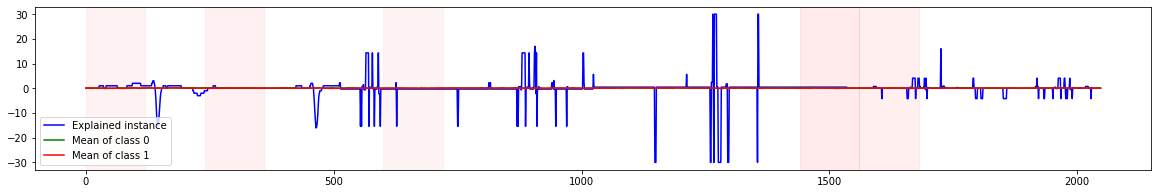

In [31]:
values_per_slice_ecg = len(series_ecg) // num_slices_ecg
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(series_ecg, 'b', label='Explained instance')
plt.plot(X_test[np.where(Y_test==0)[0]].mean(axis=0), color='green',
        label='Mean of class 0')
plt.plot(X_test[np.where(Y_test==1)[0]].mean(axis=0), color='red',
        label='Mean of class 1')
for i in range(num_features_ecg):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice_ecg
    end = start + values_per_slice_ecg
    plt.axvspan(start , end, color='red', alpha=abs(weight*100))
plt.legend(loc='lower left')
plt.show()

In [32]:
# how about original data with slide and cut
X_train2, X_test2, Y_train2, Y_test2, _ = read_data(
    DATA_PATH, window_size=win_size, stride=stride, cut=True, bit=True)

before: 
Counter({0: 4580, 1: 670}) Counter({0: 496, 1: 88})
after: 
Counter({1: 70593, 0: 70065}) Counter({1: 9412, 0: 7502})


In [33]:
class CRANN_original(nn.Module):
  """
  Input:
      X: (n_samples, n_channel, n_length)
      Y: (n_samples)
  Output:
      out: (n_samples)
  Pararmetes:
      n_classes: number of classes
  """

  def __init__(self, in_channels, out_channels, att_channels, n_len_seg, n_classes, device, verbose=False):
    super(CRANN_original, self).__init__()
    
    self.n_len_seg = n_len_seg
    self.n_classes = n_classes
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.att_channels = att_channels

    self.device = device
    self.verbose = verbose

    # (batch, channels, length)
    self.cnn = nn.Conv1d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         kernel_size=16, 
                         stride=4)
    self.cnn2 = nn.Conv1d(in_channels=self.out_channels, 
                         out_channels=self.out_channels, 
                         kernel_size=2,
                         stride=1)
    # (batch, seq, feature)
    self.rnn = nn.LSTM(input_size=(self.out_channels), 
                       hidden_size=self.out_channels, 
                       num_layers=1, 
                       batch_first=True, 
                       bidirectional=False)
    # attention
    self.W = nn.Parameter(torch.randn(self.out_channels, self.att_channels))
    self.V = nn.Parameter(torch.randn(self.att_channels, 1))
    self.dense = nn.Linear(out_channels, n_classes)

  def forward(self, x):

    self.n_channel, self.n_length = x.shape[-2], x.shape[-1]
    assert (self.n_length % self.n_len_seg == 0), "Input n_length should divided by n_len_seg"
    self.n_seg = self.n_length // self.n_len_seg

    out = x
    if self.verbose: print(out.shape) # ([128, 1, 3000])
    # out = nn.BatchNorm1d(1)(out)
    # (n_samples, n_channel, n_length) -> (n_samples, n_length, n_channel)
    out = out.permute(0, 2, 1)
    if self.verbose: print(out.shape) # ([128, 3000, 1])
    # (n_samples, n_length, n_channel) -> (n_samples*n_seg, n_len_seg, n_channel)
    out = out.view(-1, self.n_len_seg, self.n_channel)
    if self.verbose: print(out.shape) # ([7680, 50, 1])
    # (n_samples*n_seg, n_len_seg, n_channel) -> (n_samples*n_seg, n_channel, n_len_seg)
    out = out.permute(0, 2, 1)
    if self.verbose: print(out.shape) # ([7680, 1, 50])
    # cnn
    out = self.cnn(out)
    if self.verbose: print('cnn', out.shape) # ([7680, 16, 9])
    # out = nn.BatchNorm1d(self.out_channels)(out)
    out = self.cnn2(out)
    if self.verbose: print('cnn2', out.shape) # ([7680, 16, 3])
    # out = nn.BatchNorm1d(self.out_channels)(out)
    # global avg, (n_samples*n_seg, out_channels)
    out = out.mean(-1)
    if self.verbose: print('mean', out.shape) # ([7680, 16])
    # global avg, (n_samples, n_seg, out_channels)
    out = out.view(-1, self.n_seg, self.out_channels)
    if self.verbose: print(out.shape) # ([128, 60, 16])
    # rnn
    out, (_, _) = self.rnn(out) # output, (h_n, c_n)
    if self.verbose: print('rnn', out.shape) # ([128, 60, 16])
    # self attention
    e = torch.matmul(out, self.W)
    if self.verbose: print('w', e.shape) # ([128, 60, 16])
    e = torch.matmul(torch.tanh(e), self.V)
    if self.verbose: print('v', e.shape) # ([128, 60, 16])
    n1 = torch.exp(e)
    n2 = torch.sum(torch.exp(e), 1, keepdim=True)
    gama = torch.div(n1, n2)
    if self.verbose: print('g', gama.shape) # ([128, 60, 1])
    out = torch.sum(torch.mul(gama, out), 1)
    if self.verbose: print('att_out', out.shape) # ([128, 16])
    # dense
    out = nn.Dropout(0.2)(out)
    out = self.dense(out)
    if self.verbose: print(out.shape) # ([128, 2])
    
    return out

  def predict_proba(self, x):
    x = np.asarray(x).reshape(-1, 1,2048)
    if len(x.shape) < 3 or x.shape[0] == 1:
      y = F.softmax(self.forward(torch.FloatTensor(x.reshape(1, 1, -1))), dim=1)
      pred = y.cpu().data.numpy()[0]
    else:
      pred = []
      for i in range(x.shape[0]):
        y = F.softmax(self.forward(torch.FloatTensor(x.reshape(1, 1, -1))), dim=1)
        pred.append(y.cpu().data.numpy()[0])
      pred = np.asarray(pred)
    if pred.min() < 0. or pred.max() > 1.:
      print('warning: Network returning invalid probability values.')
      return x[np.where(pred<0)[0]]
    return pred

  def predict(self, x):
    if len(x.shape) < 3:
      pred = self.forward(torch.FloatTensor(x.reshape(1, 1, -1)))
      pred = pred.cpu().data.numpy()[0].argmax()
    else:
      pred = []
      for i in range(x.shape[0]):
        y = self.forward(torch.FloatTensor(x[i].reshape(1, 1, -1)))
        pred.append(y.cpu().data.numpy()[0].argmax())
      pred = np.asarray(pred)
    return pred


In [34]:
best_model2 = 'origin_CRANN_44_0.9277.pt'
crann_model2 = CRANN_original(
    in_channels=1,
    out_channels=16,
    att_channels=16,
    n_len_seg=32,
    verbose=False,
    n_classes=2,
    device=device)
crann_model2.load_state_dict(torch.load('models/'+best_model2, map_location=device))
crann_model2.eval()
# train(crann_model2, dataloader, dataloader_test, is_debug=True, summ=True)


CRANN_original(
  (cnn): Conv1d(1, 16, kernel_size=(16,), stride=(4,))
  (cnn2): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
  (rnn): LSTM(16, 16, batch_first=True)
  (dense): Linear(in_features=16, out_features=2, bias=True)
)

In [35]:
# Counter({1: 29864, 0: 29558}) Counter({0: 3348, 1: 3255})
X_test2 = X_test2.reshape(-1, 2048)
X_train2 = X_train2.reshape(-1, 2048)
idx_ecg = 0
series_ecg2 = X_test2[idx_ecg, :]
num_slices_ecg = 17
num_features_ecg = 5
explainer2 = LimeTimeSeriesExplanation(class_names=['0', '1'], feature_selection='auto')

exp2 = explainer2.explain_instance(
    series_ecg2, crann_model2.predict_proba, training_set=X_train[:100], 
    num_slices=num_slices_ecg, num_features=num_features_ecg, 
    num_samples=100, 
    replacement_method='noise')
exp2.as_list()


[(9, -0.035548711693330064),
 (13, 0.021053327222422133),
 (16, 0.01840390696107919),
 (3, 0.016024118258677732),
 (0, -0.015142790986165297)]

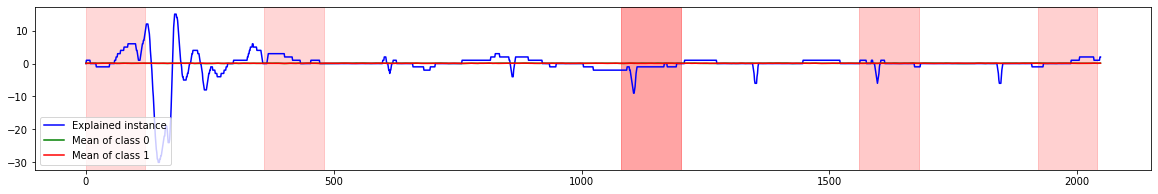

In [36]:
values_per_slice_ecg = len(series_ecg2) // num_slices_ecg
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(series_ecg2, 'b', label='Explained instance')
plt.plot(X_test2[np.where(Y_test2==0)[0]].mean(axis=0), color='green',
        label='Mean of class 0')
plt.plot(X_test2[np.where(Y_test2==1)[0]].mean(axis=0), color='red',
        label='Mean of class 1')
for i in range(num_features_ecg):
    feature, weight = exp2.as_list()[i]
    start = feature * values_per_slice_ecg
    end = start + values_per_slice_ecg
    plt.axvspan(start , end, color='red', alpha=abs(weight*10))
plt.legend(loc='lower left')
plt.show()